# Classifying Distracted Drivers Using a CNN
# Simon Schlegel

Classifying dashboard images of distracted drivers (State Farm Distracted Driver dataset).

## Imports



In [319]:
import keras
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
from keras.datasets import mnist
from keras import applications
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout, Flatten, Lambda, Dense, Activation
from keras.models import Model, Sequential
from keras.utils import np_utils
from keras.preprocessing import image    
from matplotlib import pyplot
from scipy.misc import toimage
from tqdm import tqdm
from glob import glob
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES=True
import simplejson as json
from sklearn.metrics import confusion_matrix
import os

from sklearn.model_selection import train_test_split




## Data train/test split (directories)


In [102]:
if not os.path.exists('imgs/test/c0'):
    class_subdir = os.listdir('imgs/train')[1:]
    for class_dir in class_subdir:
        imgs_fn = os.listdir('imgs/train/{}'.format(class_dir))
        train, test = train_test_split(imgs_fn, random_state=1243, test_size=0.25)
        for img in test:
            # move test images into a test folder
            os.rename('imgs/train/{}/{}'.format(class_dir, img),
                 'imgs/test/{}/{}'.format(class_dir, img))
            print("Data split into train and test directories")
else:
    print("Data already split into directories")
    
    
    

Data already split into directories


## Data augmentation 


In [340]:
trainImageDataAugGenerator = image.ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                    rotation_range = 10
                                               )
testImageDataAugGenerator = image.ImageDataGenerator(rescale = 1./255)

# validation_split = 0.225 -----
# original image sizes 640 x 480
trainImageDataFlow = trainImageDataAugGenerator.flow_from_directory('imgs/train', 
                                                target_size=(64,64), 
                                                color_mode='rgb', 
                                                class_mode='categorical',
                                                batch_size=4,
                                                shuffle=True)

testImageDataFlow = testImageDataAugGenerator.flow_from_directory('imgs/test',
                                                target_size=(64,64),
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                batch_size=1,
                                                shuffle=False)



print(len(trainImageDataFlow)*4)
print(len(testImageDataFlow)*1)


Found 16813 images belonging to 10 classes.
Found 5611 images belonging to 10 classes.
16816
5611


Visualizing some of the training images.

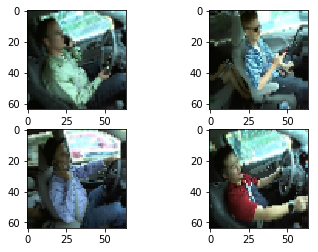

In [295]:
x_batch, y_batch = trainImageDataFlow.next()

f, axarr = plt.subplots(2, 2)
axarr[0, 0].imshow(x_batch[0])
axarr[1, 0].imshow(x_batch[1])
axarr[0, 1].imshow(x_batch[2])
axarr[1, 1].imshow(x_batch[3])

## Building the model



In [296]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our feature maps to 1D feature vectors
model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_74 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
activation_116 (Activation)  (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 29, 29, 16)        4624      
_________________________________________________________________
activation_117 (Activation)  (None, 29, 29, 16)        0         
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 3136)              0         
__________

In [297]:
optimizer = 'rmsprop'
loss = 'categorical_crossentropy'


model.compile(optimizer=optimizer, loss=loss, 
              metrics=['categorical_accuracy'])

## Training the model

In [298]:
train_steps = len(trainImageDataFlow)

history = model.fit_generator(trainImageDataFlow,
                         steps_per_epoch = train_steps,
                         epochs = 8
                   )

Epoch 1/8
4204/4204 [==============================] - 190s 45ms/step - loss: 0.8094 - categorical_accuracy: 0.7372
Epoch 2/8
4204/4204 [==============================] - 200s 48ms/step - loss: 0.2558 - categorical_accuracy: 0.9283
Epoch 3/8
4204/4204 [==============================] - 190s 45ms/step - loss: 0.1750 - categorical_accuracy: 0.9519
Epoch 4/8
4204/4204 [==============================] - 195s 46ms/step - loss: 0.1386 - categorical_accuracy: 0.9643
Epoch 5/8
4204/4204 [==============================] - 193s 46ms/step - loss: 0.1260 - categorical_accuracy: 0.9654
Epoch 6/8
4204/4204 [==============================] - 192s 46ms/step - loss: 0.1098 - categorical_accuracy: 0.9721
Epoch 7/8
4204/4204 [==============================] - 187s 44ms/step - loss: 0.1047 - categorical_accuracy: 0.9726
Epoch 8/8
4204/4204 [==============================] - 187s 45ms/step - loss: 0.0923 - categorical_accuracy: 0.9765


"# Save the weights for grading.\nmodel.save_weights('model.h5', True)\nwith open('model.json', 'w') as outfile:\n    json.dump(model.to_json(), outfile)"

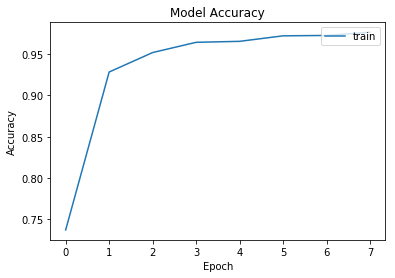

In [300]:

plt.plot(history.history['categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

model.save_weights('model.h5', True)
with open('model.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)

## Evaluation

In [344]:
# YOUR EVALUATION CODE GOES HERE
test_steps = len(testImageDataFlow)

test_pred = model.predict_generator(testImageDataFlow, steps=test_steps)
print(test_pred[0])

[9.9997413e-01 6.7628553e-10 4.2690132e-07 2.2143443e-09 7.2960935e-09
 8.8098471e-07 2.9467896e-07 2.3494803e-10 2.3706883e-05 6.4081570e-07]


Find index of largest probability in prediction array


In [345]:
pred_class = test_pred.argmax(axis=1)
true_class = testImageDataFlow.classes

print(pred_class[:9])
print(true_class[:9])

[0 8 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0]


Compute confusion matrix and accuracies for test set


In [347]:
cm = confusion_matrix(true_class, pred_class)
count = 0
for x in range(len(true_class)):
    if true_class[x] == pred_class[x]:
        count +=1
        
print('Predicted\tc0\tc1\tc2\tc3\tc4\tc5\tc6\tc7\tc8\tc9'.expandtabs(4))
print('True')
class_num = 0
for row in cm:
    str_result = 'c{}\t\t\t'.format(str(class_num))
    class_num += 1
    for entry in row:
        str_result += '{}\t'.format(str(entry))
    print(str_result.expandtabs(4))
    
print("\nTotal Accuracy: %.2f%%" % (count * 100/ len(true_class)))
col_sums = cm.sum(axis=0)
for i in range(len(cm)):
    print('c{}: {:.2f}%'.format(str(i), 100 * cm[i][i] / col_sums[i]))

class_map = ['c0  :  safe', 'c1  :  texting-right', 'c2  :  talking on phone-right',
            'c3  :  texting-left', 'c4  :  talking on phone-left',
            'c5  :  using radio', 'c6  :  drinking', 'c7  :  reaching back',
            'c8  :  hair or makeup',  'c9  :  talking to passenger']
print('\nClass directory:')
print('\n'.join(class_map))




Predicted   c0  c1  c2  c3  c4  c5  c6  c7  c8  c9
True
c0          609 3   0   1   0   0   0   0   4   6   
c1          0   564 0   0   0   0   0   0   1   2   
c2          1   3   567 1   0   0   0   0   5   3   
c3          7   1   1   572 0   0   0   0   1   5   
c4          4   0   0   6   566 1   1   0   4   0   
c5          1   0   0   0   2   573 2   0   0   0   
c6          1   2   0   0   1   0   571 0   4   3   
c7          1   1   0   0   0   0   1   486 8   4   
c8          6   5   0   2   2   1   0   0   452 10  
c9          6   0   0   1   0   1   1   0   8   516 

Total Accuracy: 97.59%
c0: 95.75%
c1: 97.41%
c2: 99.82%
c3: 98.11%
c4: 99.12%
c5: 99.48%
c6: 99.13%
c7: 100.00%
c8: 92.81%
c9: 93.99%

Class directory:
c0  :  safe
c1  :  texting-right
c2  :  talking on phone-right
c3  :  texting-left
c4  :  talking on phone-left
c5  :  using radio
c6  :  drinking
c7  :  reaching back
c8  :  hair or makeup
c9  :  talking to passenger
